<a href="https://colab.research.google.com/github/addo561/learning-pytorch/blob/main/VIT_PAPER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [6]:
train_dir = image_path/'train'
test_dir = image_path/'test'
train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [7]:
#Prepare transform
img_size = 224

manual_transform = transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor()
])
manual_transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [8]:
#batch size
batch = 32
train_dataloader,test_dataloader,class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir = test_dir,
    transform=manual_transform,
    batch_size = batch
)

In [9]:
train_dataloader, test_dataloader, class_names


(<torch.utils.data.dataloader.DataLoader at 0x7a9bb2fcc550>,
 ['pizza', 'steak', 'sushi'])

In [10]:
#visualize
image_batch,label_batch = next(iter(train_dataloader))

In [11]:
image,label = image_batch[1],label_batch[1]
image.shape,label.item()

(torch.Size([3, 224, 224]), 0)

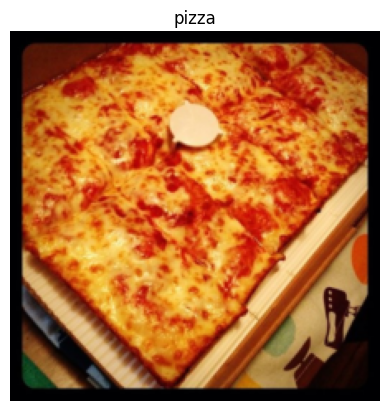

In [12]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label.item()])
plt.axis(False);

In [ ]:
#Examples
input_embedding_layer_shape = (224,224,3)#heigth(H),width(W),color channels
patch_size = 16

#Number of patches,N
N = int(input_embedding_layer_shape[0]*input_embedding_layer_shape[1]/patch_size **2)# H*W/patch_size**2
print(f'Patch Number: {N}')

In [14]:
#Embedding_output_shape -> (N ,patch_size^2 * color channels)
outputs_embedding_layer_shape = (N,patch_size**2 * input_embedding_layer_shape[2])
print(f'input_embedding_layer_shape: {input_embedding_layer_shape}')
print(f'output_layer_embedding_shape: {outputs_embedding_layer_shape}')

input_embedding_layer_shape: (224, 224, 3)
output_layer_embedding_shape: (196, 768)


View of single image patches

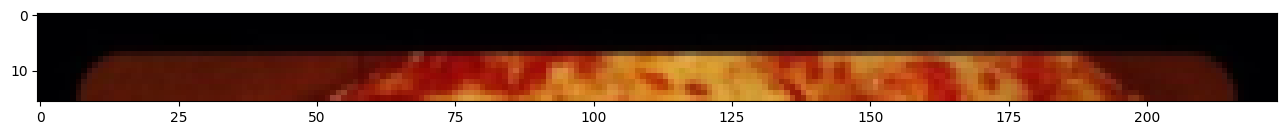

In [15]:
permuted_image = image.permute(1,2,0)#change from (C,H,W) -> (H,W,C)
Patch_size = 16
plt.figure(figsize=(Patch_size,Patch_size))
plt.imshow(permuted_image[:Patch_size,:,:])


14 patches per row
patch size  -> 16 x 16
0
16
32
48
64
80
96
112
128
144
160
176
192
208


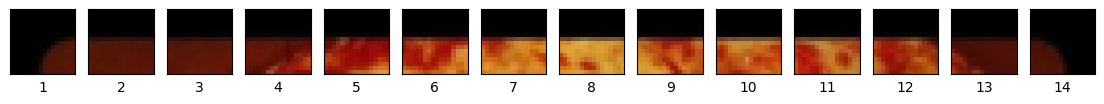

In [16]:
#patches
img_sz = 224
num_patches = img_sz/Patch_size
assert img_sz % Patch_size == 0, "Image size must be divisible by patch size"
fig,axs = plt.subplots(nrows=1,
                      ncols=img_sz//Patch_size,
                      figsize=(14,14))
print(f'{int(num_patches)} patches per row')
print(f'patch size  -> 16 x 16')
#patches in top row
for i,patch  in enumerate(range(0,img_sz,Patch_size)):
  print
  axs[i].imshow(permuted_image[:Patch_size,patch:patch+Patch_size,:]);
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])



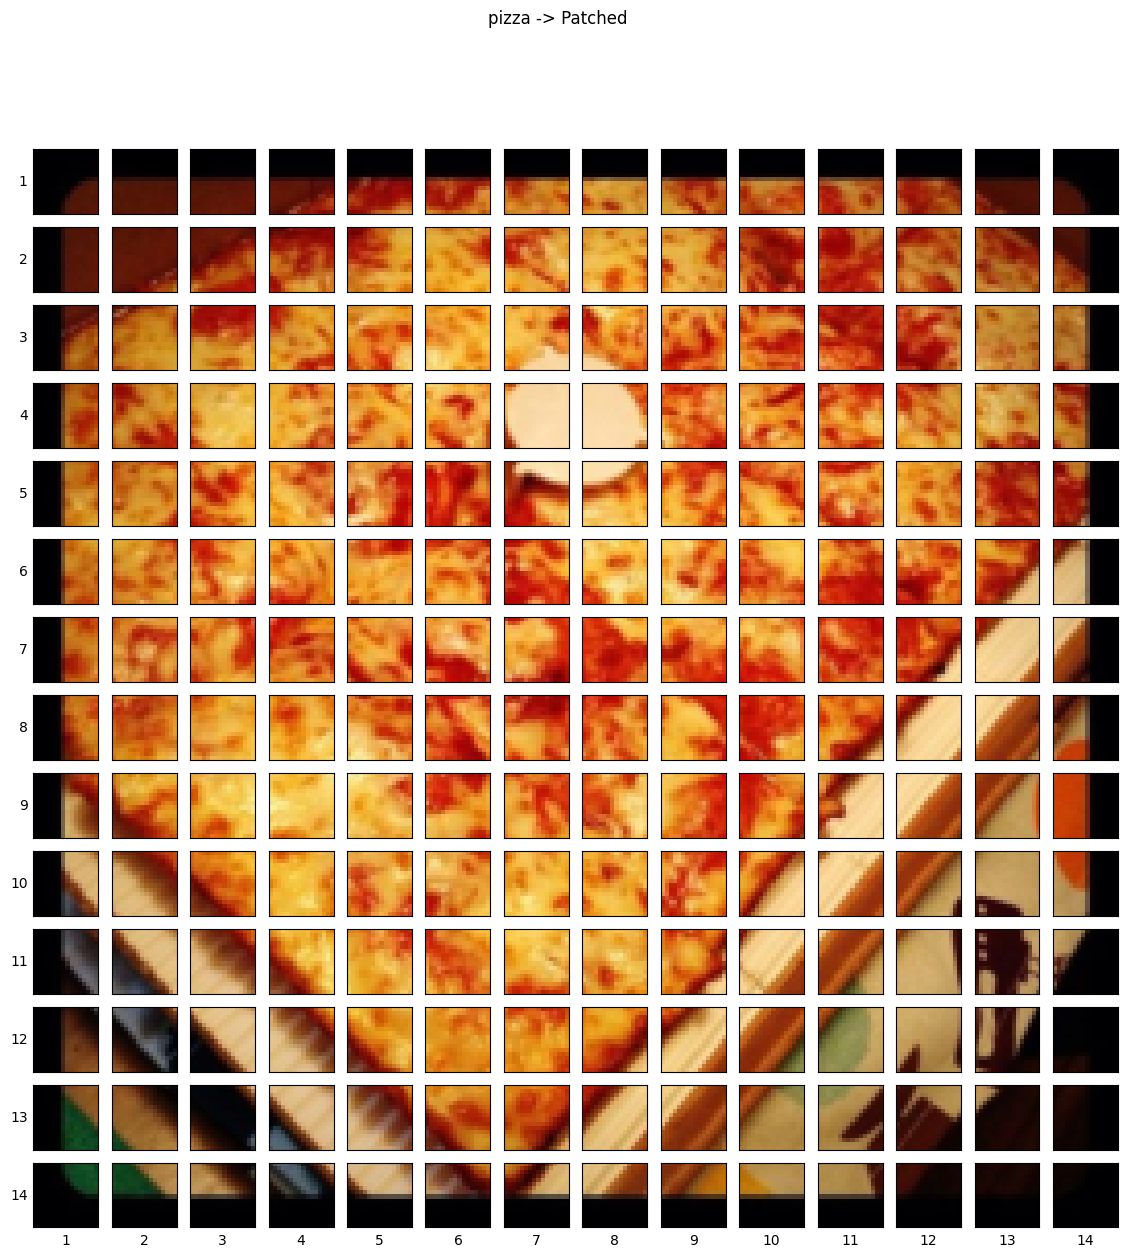

In [21]:
image_size = 224
patch_size = 16
num_patches = image_size/patch_size
assert image_size % patch_size == 0, "Image size must be divisible by patch size"
fig,axs = plt.subplots(nrows=14,
                       ncols=14,
                       sharex=True,
                       sharey=True,
                       figsize=(14,14))
#iterate through width and height
for i ,patch_h in enumerate(range(0,image_size,patch_size)):
  for j,patch_w in enumerate(range(0,image_size,patch_size)):
    axs[i,j].imshow(permuted_image[patch_h:patch_h+patch_size,patch_w:patch_w+patch_size,:]);
    axs[i,j].set_ylabel(i+1,
                        rotation='horizontal',
                        horizontalalignment='right',
                        verticalalignment='center')
    axs[i,j].set_xlabel(j+1)
    axs[i,j].set_xticks([])
    axs[i,j].set_yticks([])
    axs[i,j].label_outer()
fig.suptitle(f'{class_names[label.item()]} -> Patched')
plt.show()
